In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
### 256, pas augment, 15% dataset, res18, 5 epoch ==> 0.76 error rate en 5 epoch
### 256,     augment, 15% dataset, res18, 5 epoch ==> 0.74 error rate en 5 epoch
### 512,     augment, 15% dataset, res18, 5 epoch ==> 0.59 error rate en 5 epoch#
### 512,     augment, 15% dataset, res34,50 epoch ==> 0.02 error rate en 50 epoch# ==> O.35 dans la leaderborad, problème val-set non représentatif 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from competition_library import *
from fastai.vision.all import *


In [25]:
from fastai.vision.all import *
path = "/home/remi/Documents/kaggle_data/train_images/"
files = get_image_files(path)

In [26]:
split_file = randomly_subsample(files,prob_keep=0.5)

In [29]:
f = open("/home/remi/Documents/kaggle_data/train_cultivar_mapping.csv","r")
f.readline()
image_to_category = {}
for i in f.readlines():
    split = i.split(",")
    image_to_category[split[0]]= split[1].replace("\n", "")
    #print(i.split(","))
f.close()

In [30]:
def label_func(path_obj):
    return image_to_category[os.path.basename(path_obj)]

In [31]:
dls = ImageDataLoaders.from_name_func(path, split_file, label_func, item_tfms=Resize(64*4*2),bs=32,batch_tfms=aug_transforms())

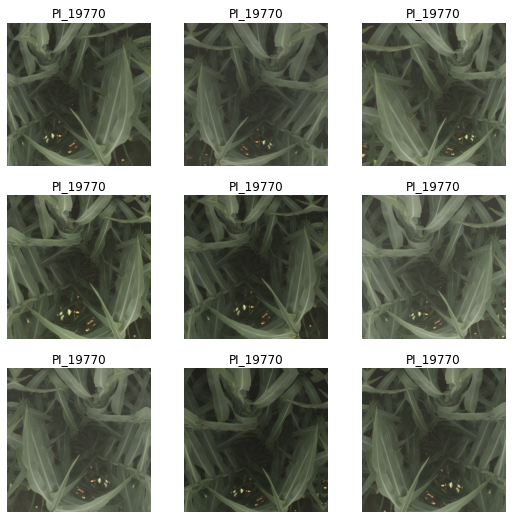

In [32]:
dls.show_batch(unique=True)

In [33]:
dls.bs, len(split_file)

(32, 11152)

In [14]:
learn.load("/home/remi/Documents/kaggle_data/train_images/models/model")

/home/remi/anaconda3/envs/fastaiv2GPU/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [15]:
tst_files = get_image_files("/home/remi/Documents/kaggle_data/test/").sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

tensor([52, 93, 99,  ..., 22,  4, 67])

In [19]:
list_df =[] 
list_cultivar =[] 

for i in tqdm(range(len(tst_files))):#    len(tst_files)):
    list_df.append(os.path.basename(tst_files[i]))
    list_cultivar.append(dls.vocab[idxs[i]])


100%|██████████| 23639/23639 [00:01<00:00, 14333.86it/s]


In [20]:
import pandas as pd
d = {'filename': list_df, 'cultivar': list_cultivar}
df = pd.DataFrame(d)
df

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_329333
2,1000135300.png,PI_92270
3,1000136796.png,PI_329256
4,1000292439.png,PI_273969
...,...,...
23634,999578153.png,PI_156217
23635,999692877.png,PI_273465
23636,999756998.png,PI_152967
23637,999892248.png,PI_146890


In [21]:
df.to_csv('submissionRemi.csv', index=False)